
**Nom**: Bo shao\
**NIU**: 1671000

**Nom**: Xiang Feng Wang\
**NIU**: 1674571




# Students Academic Performance

---

In [1]:
import pandas as pd

import numpy as np

import missingno as msno

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, cross_validate, learning_curve


## 1. INTRODUCCION

El objetivo de este estudio es analizar el rendimiento académico global del alumnado y desarrollar modelos de predicción que permitan estimar sus notas a partir de distintos factores personales y escolares. El conjunto de datos contiene información sobre el género, el grupo étnico, el nivel educativo de los padres, el tipo de ayuda de comedor, la realización o no de un curso preparatorio para los exámenes y las puntuaciones obtenidas en matemáticas, lectura y escritura.

A partir de estas variables se pretende construir un modelo capaz de predecir el rendimiento de los estudiantes, por ejemplo, identificar alumnado de alto o bajo rendimiento para que el centro educativo pueda detectar con antelación posibles situaciones de riesgo y planificar acciones de ayuda para cada alumno, como las tutorías, refuerzos, etc. Por lo que el centro puede mejorar los resultados globales y reducir las diferencia de notas entre los grupos de estudiantes.

In [2]:
dataset = pd.read_csv("dataset/StudentsPerformance.csv")
dataset.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


---

## 2. ANÁLISIS DE DATOS

Empezamos analizando que contiene nuestro dataset.

In [3]:
print(f"El dataset StudentsPerformance contiene {dataset.shape[0]} muestras y {dataset.shape[1]} atributos.")

El dataset StudentsPerformance contiene 1000 muestras y 8 atributos.


Ejecutaremos la función detectarAtributosCategoricos para identificar que variables del conjunto de datos se tratarán como categóricas y numéricas. Esta función revisa cada columna, comprueba su tipo y calcula la proporción de valores únicos en función de un umbral (threshold) y decide si una variable numérica debe considerarse categórica o no. El resultado es un diccionario con dos listas que son la categorica y numerica. 

In [4]:
def detectarAtributosCategoricos(df, threshold=0.05):
    
    feature_types = {
        "categorica": [],
        "numerica": []
    }
    
    for col in df.columns:
        if df[col].dtype == "object":
            feature_types["categorica"].append(col)
        else:
            if df[col].nunique() / len(df) < threshold:
                feature_types["categorica"].append(col)
            else:
                feature_types["numerica"].append(col)
    
    return feature_types

feature_types = detectarAtributosCategoricos(dataset)
print("Atributos categóricos:", feature_types["categorica"])
print("Atributos numéricos:", feature_types["numerica"])



Atributos categóricos: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Atributos numéricos: ['math score', 'reading score', 'writing score']


In [5]:
for col in dataset.columns:
    if dataset[col].dtype == "object":
        tipo = "Categórico"
    else:
        tipo = "Numérico"
    print(f"{col}: {tipo}")

gender: Categórico
race/ethnicity: Categórico
parental level of education: Categórico
lunch: Categórico
test preparation course: Categórico
math score: Numérico
reading score: Numérico
writing score: Numérico


Como hemos mencionado antes, la función detectarAtributosCategoricos imprime dos listas, una con los atributos que se consideran categóricos y otra con los que se consideran numéricos.Despues mediante un bucle sobre todas las columnas del dataset, se indica el tipo de dato real de cada atributo, es deicr, si en el fichero es de tipo object se marca como “Categórico” y sino como “Numérico”. 
Comparando estas dos salidas y podemos ver que si coinciden los tipos detectados con los tipos reales, o sea, la clasificación coincide con el tipo de dato real, por lo tanto, no se ha detectado ningún atributo numérico que deba tratarse como categórico.

A continuación, se realizará una descripción de cada atributo para analizar el significado de cada uno de ellos.

**gender (Categórico)**: indica el género del estudiante. Toma valores como female o male.

**race/ethnicity (Categórico)**: agrupa los alumnos en distintos grupos étnicos/raciales (A, B, C, D, E). No son categorías numéricas, sino etiquetas que representan diferentes colectivos.

**parental level of education (Categórico)**: recoge el nivel educativo más alto alcanzado por los padres o tutores del estudiante (high school, associate’s degree, bachelor’s degree, etc.).

**lunch (Categórico)**: indica el tipo de comida escolar que recibe el estudiante, entre la comida estándar y comida subvencionada o reducida (standard, free, reduced).

**test preparation course (Categórico)**: señala si el estudiante ha realizado o no un curso de preparación específico para los exámenes (none, completed).

**math score (Numérico)**: puntuación obtenida por el estudiante en el examen de matemáticas. Se expresa como una nota numérica entre 0 y 100.

**reading score (Numérico)**: puntuación obtenida en el examen de comprensión lectora, también en formato numérico.

**writing score (Numérico)**: puntuación del estudiante en el examen de escritura, también en formato numérico.

Seguidamente, haremos un análisis más detallado de los atributos numéricos del conjunto de datos. En este caso, nos centraremos en las tres notas del alumnado que son math score, reading score y writing score, ya que representan directamente el rendimiento académico que queremos estudiar y predecir. 
Mediante la función describe mostraremos las estadísticas básicas de estos atributos numéricos.

In [6]:
dataset.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


En la tabla anterior se puede observar que math score, reading score y writing score, tienen 1000 muestras (count) y está medida en una escala de 0 a 100. Las medias se sitúan alrededor de los 66 a 69 y las desviaciones típicas en torno a 15 puntos, es decir, que la mayoría de estudiantes tienen notas cercanas a la media.
Los valores mínimos (min) muestran que existen estudiantes con rendimientos muy bajos como el 0 en matemáticas, 17 en lectura y 10 en escritura, mientras que los máximos tienen 100 en las tres asignaturas. Los valores del 25 %, 50 % (casi iagual a la media) y 75 % son también muy parecidos en las tres variables. Esto indica que las notas de matemáticas, lectura y escritura se reparten de forma similar y lo que quiere decir es que si un alumno obtiene buenas notas en una asignatura suele obtener buenas notas en las otras. Más adelante se analizará esta relación con la matriz de correlaciones. Ademas, podemos ver que ninguna de las tres variables numéricas es constante ni tampoco tienen comportamiento categórico, por lo tanto, todas aportan información útil que no debemos eliminar y se mantendrán en el conjunto de datos.

A continuación, mostraremos la matriz de correlaciones de las variables numéricas para identificar la relación entre ellas y, de este modo, entender mejor cómo interactúan las diferentes variables y cómo pueden influir en los resultados de la predicción de los modelos.

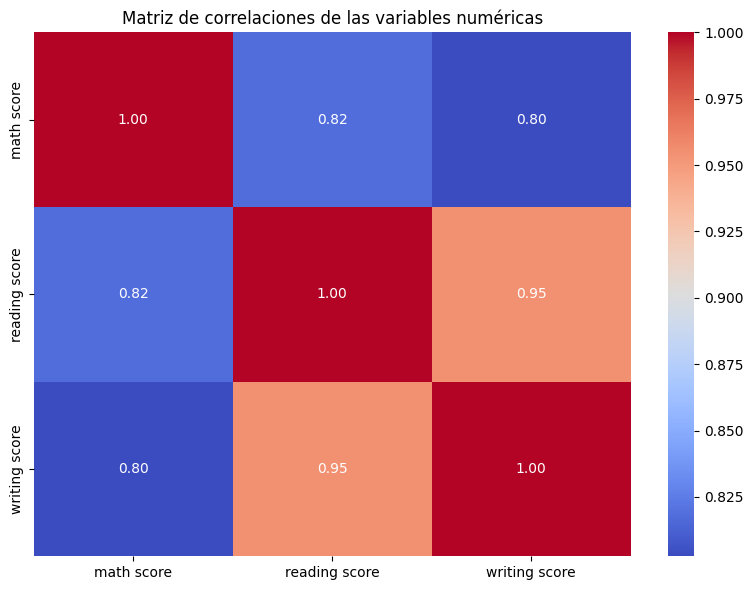

In [7]:
datos_numericos = dataset.select_dtypes(include=["number"])

matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones de las variables numéricas")
plt.tight_layout()
plt.show()

En la matriz de correlaciones anterior se puede ver que las tres variables numéricas están muy relacionadas entre sí. La correlación entre reading score y writing score es muy alta (0,95), lo que nos puede indicar que el alumnado que obtiene buenas notas en lectura suele sacar buenas notas en escritura. Las correlaciones de math score con las otras dos notas también son elevadas (0,80 para writing score y 0,82 para reading score), asi que un buen rendimiento en una de las asignaturas suele ir relacionado de buenos resultados en las demás asignaturas. Estas correlaciones tan altas nos indican que las tres variables describen un rendimiento académico global muy parecido, por lo tanto, lo tendremos en cuenta al construir los modelos de predicción.

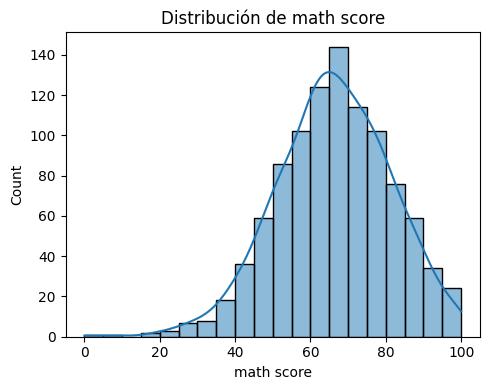

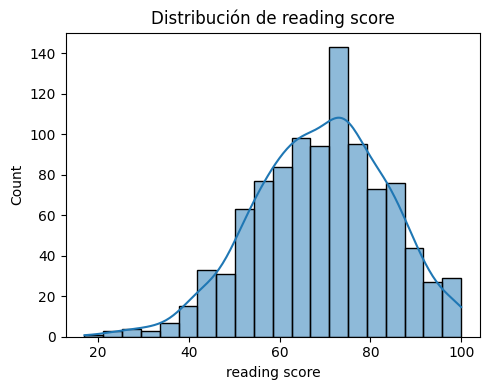

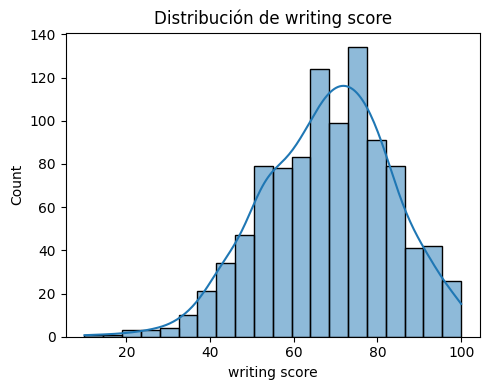

In [8]:
for col in ["math score", "reading score", "writing score"]:
    plt.figure(figsize=(5, 4))
    sns.histplot(dataset[col], kde=True, bins=20)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


En las tres graficas anteriores de math score, reading score y writing score son bastante similares, o sea vemos que la mayoría de estudiantes se concentra en notas medias entre 60 y 80 puntos, y hay menos alumnos con notas muy bajas o muy altas. Esto coincide y corroborar con la matriz de correlaciones anterior, por lo tanto, ya mencionado anteriormente las tres variables representan un patrón de rendimiento académico muy similar.

A continuacion, haremos el análisis de las variables categóricas. Este análisis es importante para comprender la composición de los alumnos y detectar posibles desequilibrios entre categorías que puedan influir en los resultados de los modelos. Las variables categóricas que se estudiarán son, gender, race/ethnicity, parental level of education, lunch y test preparation course.
Y hemos de comentar de que en este conjunto de datos no tenemos variables temporales, por lo que no se realizará un análisis temporal.

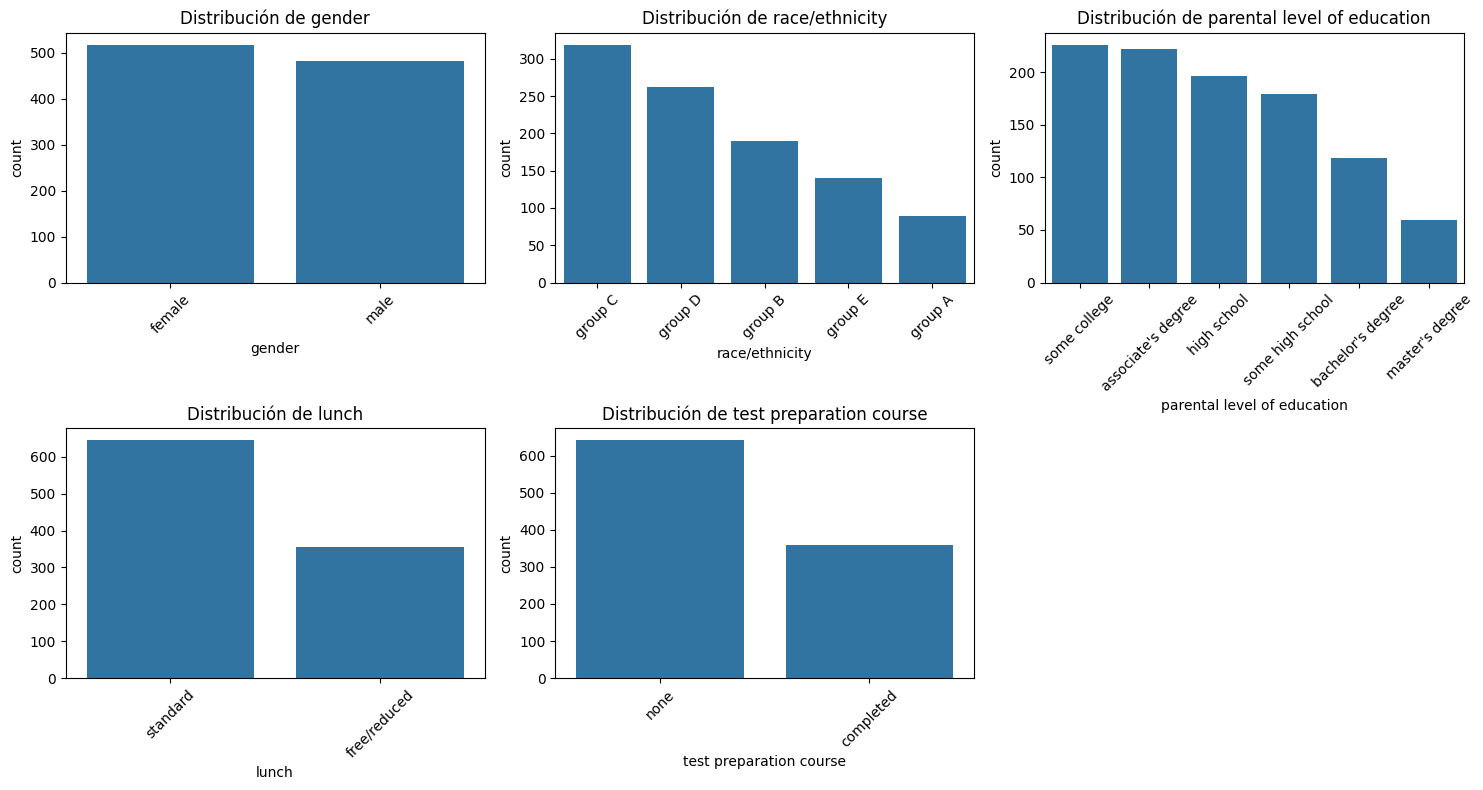

In [9]:
columnas = ["gender","race/ethnicity","parental level of education","lunch","test preparation course",]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, col in zip(axes, columnas):
    sns.countplot(
        data=dataset,
        x=col,
        order=dataset[col].value_counts().index,
        ax=ax
    )
    ax.set_title(f"Distribución de {col}")
    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(columnas):]:
    ax.axis("off")

plt.tight_layout()
plt.show()



A partir de los gráficos anteriores se observa que la variable gender presenta una distribución bastante equilibrada entre female y male. En race/ethnicity aparece una distribucion no tan equilibrada, podemos ver que el grupo C es el más frecuente, seguido de los grupos D y B, mientras que los grupos A y E son los que tienen menos alumnos.
En parental level of education dominan los niveles some college y associate’s degree, mientras que el nivel master’s degree es el menos frecuente. Esto indica que la mayoría de familias tiene un nivel educativo medio, y solo una parte pequeña alcanza estudios de máster.
La variable lunch muestra que una proporción mayor de estudiantes recibe comida estándar frente a comida gratuita o reducida, esto puede estar relacionado con la situación económica del alumno. 
Finalmente, en test preparation course se ve que la mayoría de estudiantes no han hecho ningun curso de preparación, y solo una parte menor lo ha completado.

Estas distribuciones permiten entender mejor la composición del conjunto de datos y serán útiles más adelante para interpretar cómo influyen estas características categóricas en el rendimiento académico que se quiere predecir.

Una vez analizadas por separado las variables numéricas y categóricas, vamos a definir la variable objetivo del problema. En este caso, el objetivo será el rendimiento académico global de cada estudiante, que se calcula como la media de las tres notas disponibles en el dataset, que son el math score, reading score y writing score. Por lo tanto, se crea una nueva columna llamada average_score que contiene la media y que será el target de los modelos de predicción. Despues, se estudiará cómo se comporta average_score en función de cada una de las variables categóricas (gender, race/ethnicity, parental level of education, lunch y test preparation course) para identificar posibles patrones y diferencias entre grupos de alumnado.

In [10]:
dataset["average_score"] = dataset[["math score", "reading score", "writing score"]].mean(axis=1)

dataset["average_score"].describe()


count    1000.000000
mean       67.770667
std        14.257326
min         9.000000
25%        58.333333
50%        68.333333
75%        77.666667
max       100.000000
Name: average_score, dtype: float64

In [11]:
dataset.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Podemos observar que esta variable average_score tiene 1000 valores con una media aproximada de 67,77 puntos y una desviación típica de unos 14,3 puntos. Y los valores de 58,3 (25 %), 68,3 (50 %) y 77,7 (75 %), nos indica que la mayoría del alumnado obtiene una nota media entre 58 y 78 puntos.
El valor mínimo de average_score es 9 y el máximo es 100, por lo que existen estudiantes con un rendimiento muy bajo como alumnos con una nota media perfecta. En el head (5) del dataset se puede comprobar que la nueva columna del atributo average_score se ha añadido correctamente. A partir de ahora, esta será la variable objetivo que se intentará predecir a partir del resto de atributos.

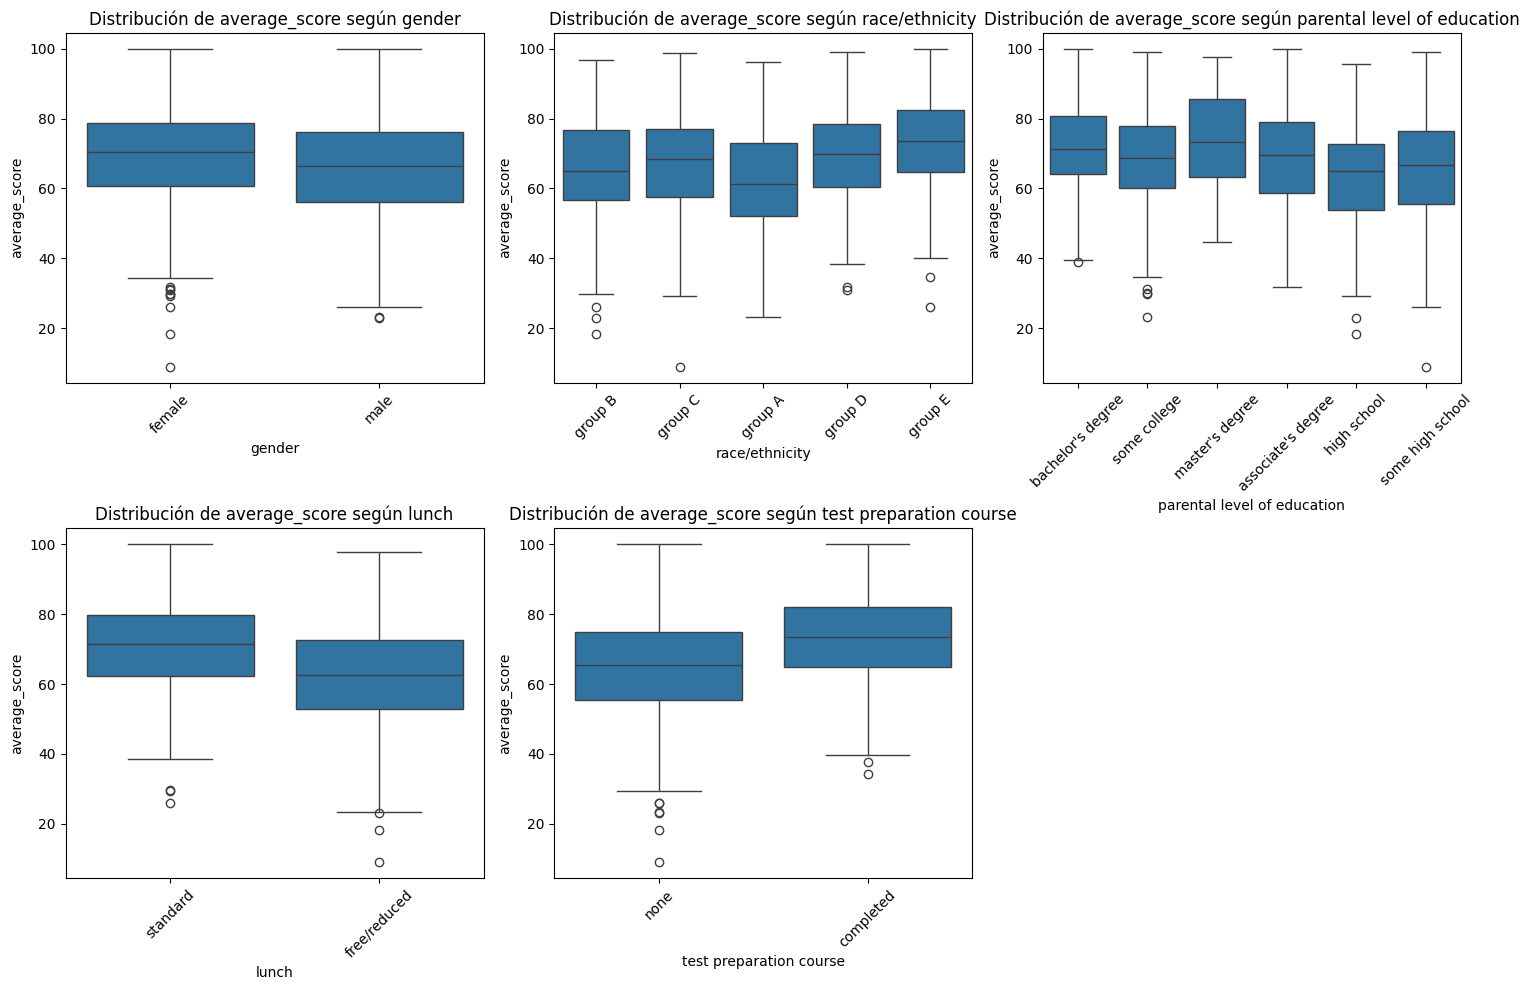

In [12]:
atributos_categoricos = ["gender","race/ethnicity","parental level of education","lunch","test preparation course"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, atributos_categoricos):
    sns.boxplot(
        data=dataset,
        x=col,
        y="average_score",
        ax=ax
    )
    ax.set_title(f"Distribución de average_score según {col}")
    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(atributos_categoricos):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


A partir de los gráficos anteriores se observa que la nota media average_score no se reparte igual en todos los atributos categóricos.

En gender, la distribución de average_score es similar entre female y male, pero las estudiantes femeninas tienen nota media un poco superior. Podemos decir que las chicas tienden a obtener mejores resultados.

En race/ethnicity se aprecian diferencias entre grupos, o sea el rendimiento académico medio varía según el grupo étnico al que pertenece el alumnado, por ejemplo algunos grupos (como D y E) sus notas medias son más altas, mientras que otros son más bajos.

Para parental level of education se ve una tendencia bastante clara, porque a medida que aumentamos el nivel educativo de los padres por ejemplo, pasando de high school a bachelor’s degree o master’s degree, la nota media del estudiante tiende a ser mayor. Esto nos quiere decir que el contexto educativo familiar tienen una influencia positiva en el rendimiento académico del alumno.

En lunch, el alumno con comida de tipo standard suele tener valores de average_score superiores a los que reciben comida free/reduced.

Y en test preparation course se observa que los estudiantes que han completado el curso de preparación obtienen una nota media más alta que aquellos que no lo han realizado. Este resultado indica que la participación en este tipo de cursos puede tener un impacto muy positivo en el rendimiento de los exámenes.

En conjunto, estos análisis muestran que variables como test preparation course, lunch y parental level of education parecen estar muy relacionadas con average_score, por lo que probablemente aportarán información útil a la hora de construir el modelo de predicción del rendimiento académico.


A continuación, se mostrará en una matriz si existen valores faltantes (nulos) en el dataset, para poder realizar un tratamiento en el caso de que los haya.

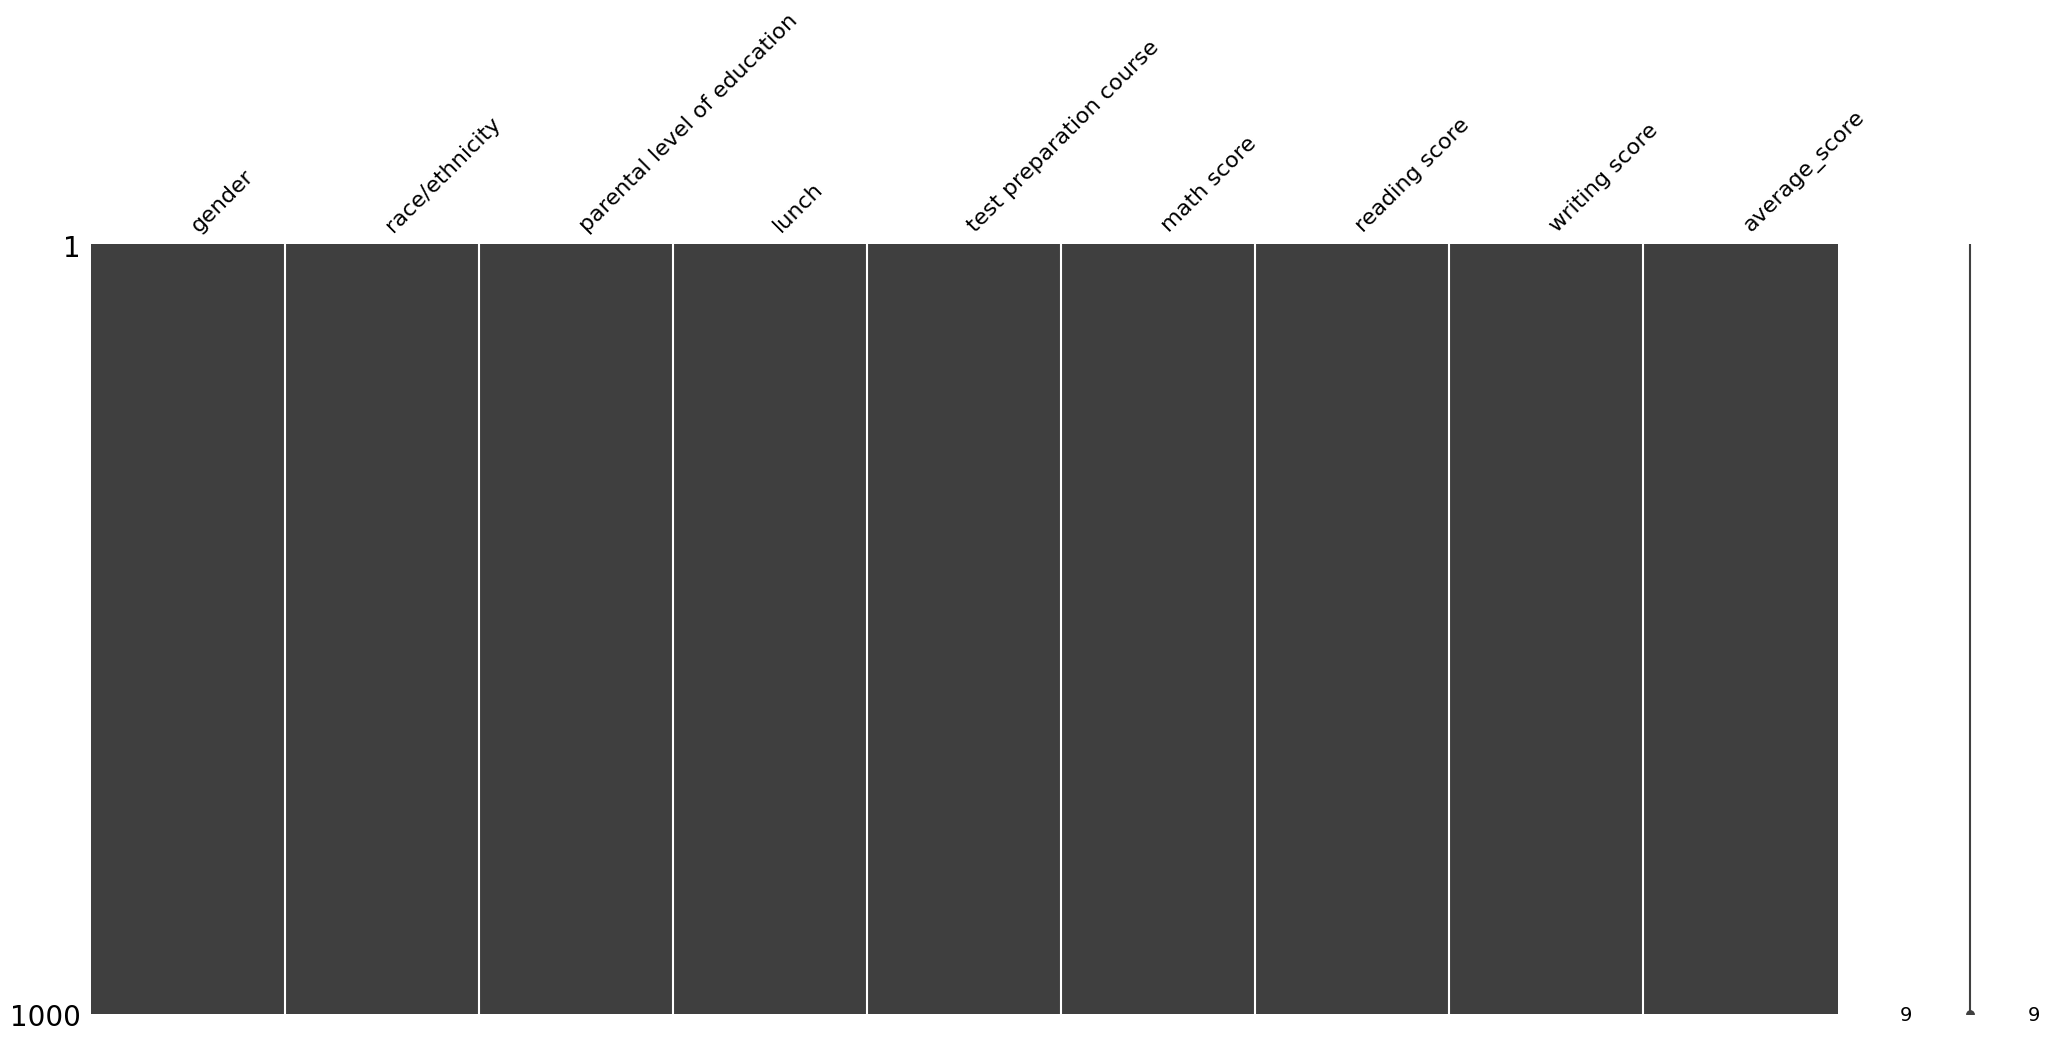

In [13]:
msno.matrix(dataset)
plt.show()

In [14]:
dataset.isnull().sum()


gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
average_score                  0
dtype: int64

Podemos observar que a partir de la matriz de valores nulos y del recuento con dataset.isnull().sum() se observa que no hay valores nulos en ninguna de las columnas del conjunto de datos. Por tanto, no es necesario realizar un tratamiento de valores faltantes.

## 3. PREPROCESAMIENTO DE DATOS

En este apartado 3 se realizará el procesamiento necesario para preparar el conjunto de datos antes de la fase de modelado. El objetivo es dejar las variables en un formato adecuado para poder entrenar y evaluar correctamente los modelos de predicción del rendimiento académico. Lo que haremos sera dividir el conjunto de datos en dos, uno que sera un subconjunto de entrenamiento y otro de prueba, para que el modelo se entrene con una parte de los datos y evalue con la otra parte, aso podemos medir su rendimiento real sobre ejemplos que no se han visto anteriormente.

A continuación, todas las transformaciones que se apliquen (como la codificación de las variables categóricas mediante one-hot encoding) se realizarán únicamente utilizando el conjunto de entrenamiento y después se trasladarán al conjunto de prueba.

In [15]:
X = dataset[["gender","race/ethnicity","parental level of education","lunch","test preparation course"]]

y = dataset["average_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


Como se ha comentado en el análisis de datos, este dataset no tiene valores nulos, por lo que no es necesario realizar ningún preprocesamiento adicional relacionado con valores faltantes. Por tanto, a continuación se continuará con la codificación de las variables categóricas, ya que los modelos necesitan que los datos de entrada estén en formato numérico, ya que no pueden trabajar directamente con variables categóricas. En nuestro caso, las variables que se utilizarán para predecir son gender, race/ethnicity, parental level of education, lunch y test preparation course, son de tipo categórico.


In [16]:
pd.DataFrame(X_train.dtypes, columns=["tipo"])


,tipo
gender,object
race/ethnicity,object
parental level of education,object
lunch,object
test preparation course,object


En la tabla anterior se puede comprobar que todas las variables de entrada gender, race/ethnicity, parental level of education, lunch y test preparation course son de tipo object, es decir categóricas. La variable objetivo average_score es numérica, por lo que no necesita ningún método de codificación sobre el target. Sin embargo, como hemos comentado antes los modelos no pueden trabajar directamente con las variables categóricas de entrada, por lo que es necesario transformarlas en variables numéricas, por eso utilizaremos un one-hot encoding, que creará una columna binaria (0/1) para cada categoría de las variables gender, race/ethnicity, parental level of education, lunch y test preparation course. 

En el caso de las variables binarias como gender, lunch y test preparation course, se utiliza LabelEncoder(), ya que solo tienen dos categorías y no es necesario recurrir a otros métodos de codificación que aumentarían la dimensionalidad sin aportar beneficios, como podría ser OneHotEncoder(). por lo tanto, cada una de estas variables se transforma en una columna numérica donde se asignan los valores 0 y 1. En concreto, gender se codifica como 0 para female y 1 para male, en lunch se codifica como 0 para free/reduced y 1 para standard, y test preparation course se codifica como 0 para none y 1 para completed.

In [17]:
# gender (female / male)
le_gender = LabelEncoder()
X_train["gender"] = le_gender.fit_transform(X_train["gender"])
X_test["gender"]  = le_gender.transform(X_test["gender"])

# lunch (standard / free-reduced)
le_lunch = LabelEncoder()
X_train["lunch"] = le_lunch.fit_transform(X_train["lunch"])
X_test["lunch"]  = le_lunch.transform(X_test["lunch"])

# test preparation course (none / completed)
le_prep = LabelEncoder()
X_train["test preparation course"] = le_prep.fit_transform(X_train["test preparation course"])
X_test["test preparation course"]  = le_prep.transform(X_test["test preparation course"])
X_train.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course
382,1,group C,master's degree,0,1
994,1,group A,high school,1,1
982,1,group B,some high school,1,0
47,0,group C,high school,1,1
521,0,group C,associate's degree,1,1


In [18]:
X_test.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course
507,1,group B,bachelor's degree,0,1
818,0,group B,high school,0,1
452,0,group C,associate's degree,0,1
368,0,group A,some high school,0,1
242,0,group D,high school,1,1


Podemos observar que se han aplicado bien el LabelEncoder() para las columnas de gender, lunch y test preparation course.

A continuación, para las variables que tienen más de dos categorías se utiliza OneHotEncoder. En el caso de race/ethnicity, hay cinco grupos (A, B, C, D y E) y no existe un orden numérico claro entre ellos. Por eso si usamos LabelEncoder, el modelo pensaría que un grupo es mayor que otro, por ejemplo group E > group A, y esto no tiene sentid. Por eso se aplica un one-hot encoding.

La variable parental level of education tiene varios niveles educativos (high school, some college, associate’s degree, bachelor’s degree, master’s degree, etc.). Aunque podríamos ordenarlos de menor a mayor nivel, no sabemos si la relación con la nota media es realmente lineal. Por este motivo también se usa OneHotEncoder para garantizar que los modelos interpreten correctamente los datos.

In [19]:
# OneHotEncoder para race/ethnicity
encoder_race = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

race_train = encoder_race.fit_transform(X_train[["race/ethnicity"]])
race_test  = encoder_race.transform(X_test[["race/ethnicity"]])

race_cols = encoder_race.get_feature_names_out(["race/ethnicity"])

race_train_df = pd.DataFrame(race_train, columns=race_cols, index=X_train.index)
race_test_df  = pd.DataFrame(race_test,  columns=race_cols, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=["race/ethnicity"]), race_train_df], axis=1)
X_test  = pd.concat([X_test.drop(columns=["race/ethnicity"]),  race_test_df],  axis=1)

# OneHotEncoder para parental level of education
encoder_edu = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

edu_train = encoder_edu.fit_transform(X_train[["parental level of education"]])
edu_test  = encoder_edu.transform(X_test[["parental level of education"]])

edu_cols = encoder_edu.get_feature_names_out(["parental level of education"])

edu_train_df = pd.DataFrame(edu_train, columns=edu_cols, index=X_train.index)
edu_test_df  = pd.DataFrame(edu_test,  columns=edu_cols, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=["parental level of education"]), edu_train_df], axis=1)
X_test  = pd.concat([X_test.drop(columns=["parental level of education"]),  edu_test_df],  axis=1)

X_train.head(5)

,gender,lunch,test preparation course,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school
382,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
994,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
982,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
521,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test.head(5)

,gender,lunch,test preparation course,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school
507,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
818,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
452,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
242,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Podemos ver que se ha aplicado bien el OneHotEncoder para race/ethnicity y parental level of education. Y todas las variables de entrada son binarias (0/1), porque se han codificado con LabelEncoder o con OneHotEncoder. Esto significa que todas las características comparten la misma escala y no hay problemas de magnitudes muy distintas entre ellas, por lo tanto, no se aplica ningún proceso adicional de normalización sobre las variables, por ejemplo la normalización MinMaxScaler.

Seguidamente, analizamos la relación entre las distintas variables de entrada y la variable target average_score, por lo tanto, se muestra la matriz de correlaciones calculada a partir del conjunto de entrenamiento. 

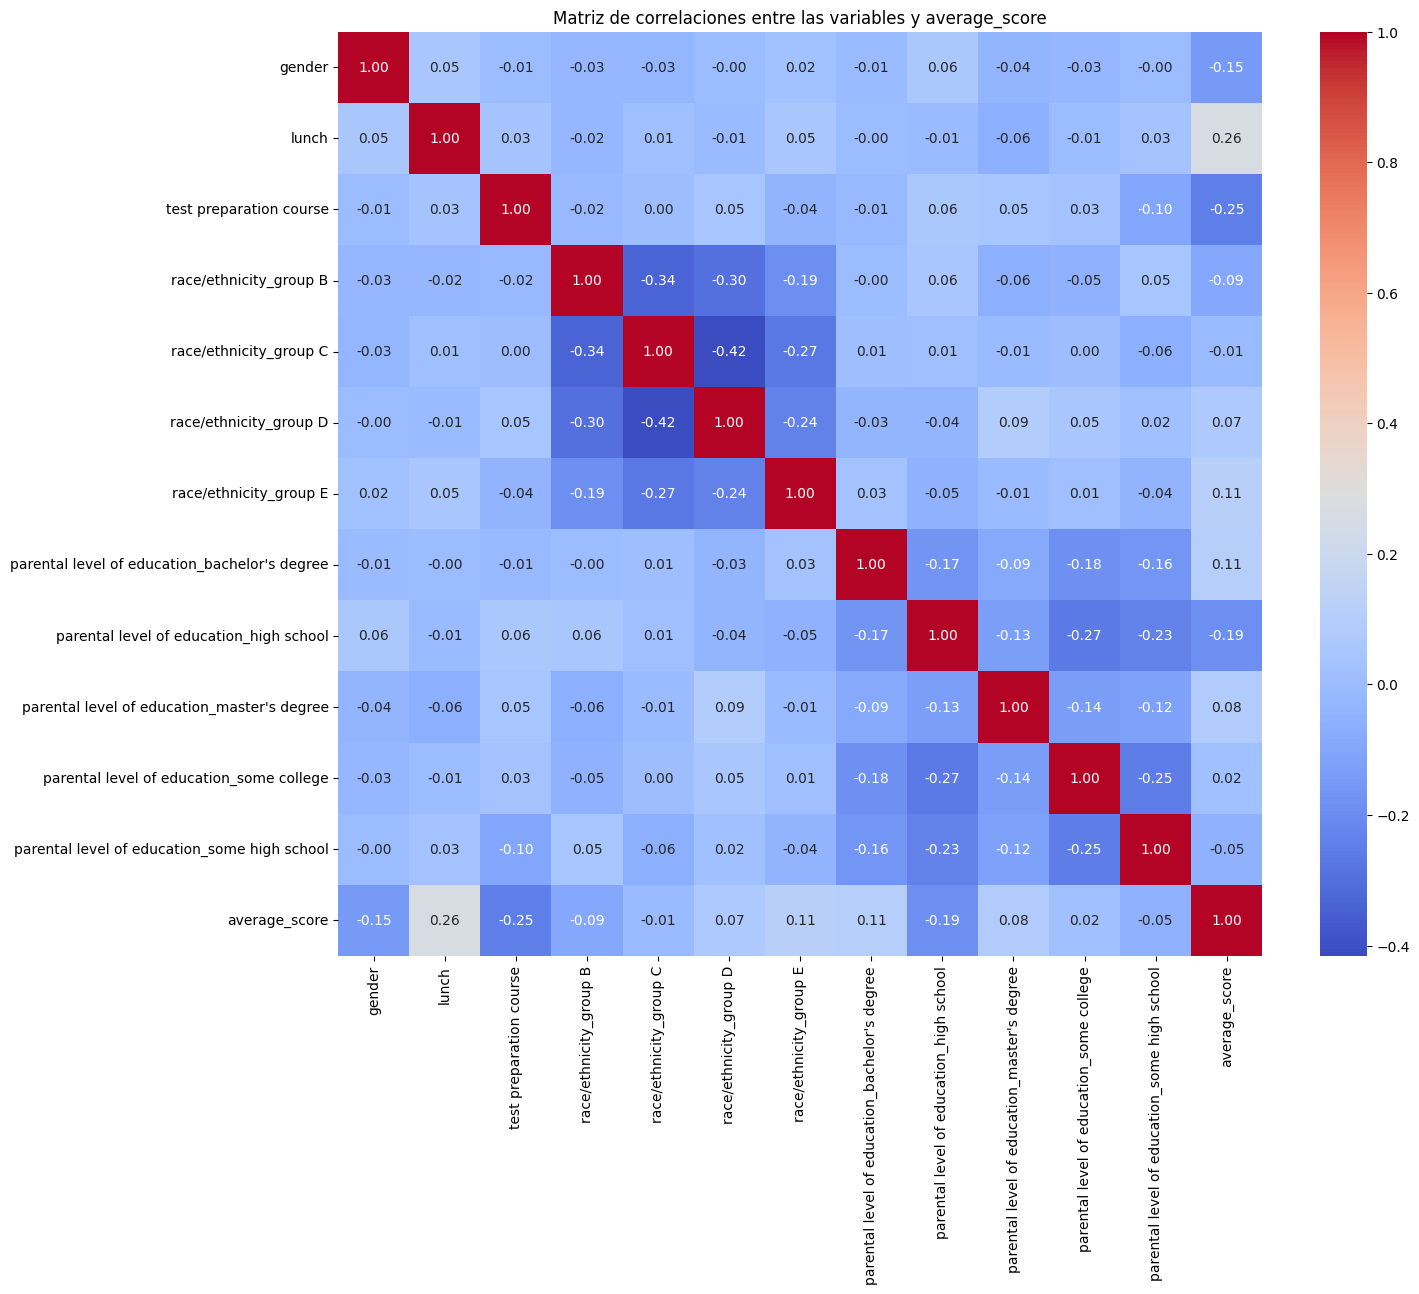

In [21]:
corr_df = X_train.copy()
corr_df["average_score"] = y_train.values

matriz_correlacion = corr_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlaciones entre las variables y average_score")
plt.show()


Observando la matriz anterior, en la última fila o columna que corresponde a la variable objetivo average_score, vemos que las correlaciones más destacadas o sea más alta, son el lunch (0.26) el valor positivo indica que los estudiantes con comida de tipo standard tienden a obtener una nota media más alta que aquellos con comida free/reduced. En test preparation course (-0.25), teniendo en cuenta que la codificación utilizada asigna valores más altos a los alumnos que no han realizado el curso de preparación, por lo que la correlación negativa indica que participar en el curso está asociado a una mayor nota media. Y algunos niveles de parental level of education, como  bachelor’s degree (0.11) y master's degree (0.08), también muestran correlaciones positivas con average_score, mientras que niveles más bajos como high school (-0.19) o some high school (-0.05) tienen correlaciones negativas. Esto coincide con el análisis anterior, donde se observaba que un mayor nivel educativo de los padres suele influir en tener mejores resultados académicos.

Ademas, si nos fijamos en las correlaciones entre las variables categoricas, casi todos los valores son bajos y muy cerca del 0, por lo tanto, nos indica que los atributos categóricas no están fuertemente relacionadas entre ellos y no son redundantes. Por eso decidimos mantener todas las variables codificadas en el modelo, ya que cada una aporta información diferente sobre el alumno y no se detectan atributos redundantes que sea necesario eliminar para reducir la dimensionalidad. En cuanto a correlacion de los atributos respecto el target hacemos lo mismo, es decir, mantener todos los atributos porque presentan correlaciones bajas.

Finalmente, presentamos el conjunto de datos de entrenamiento una vez completado todo el proceso de preprocesado de datos. En los siguientes apartados se seleccionarán las métricas más adecuadas y se entrenarán los modelos de regresión para evaluar su capacidad de predecir la nota media average_score.

In [22]:
X_train.head(5)

,gender,lunch,test preparation course,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school
382,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
994,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
982,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
521,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. SELECCIÓN DE MÉTRICAS

En este apartado se decidirán las métricas que se utilizarán para evaluar el rendimiento de los modelos de regresión que intentarán predecir la nota media average_score.

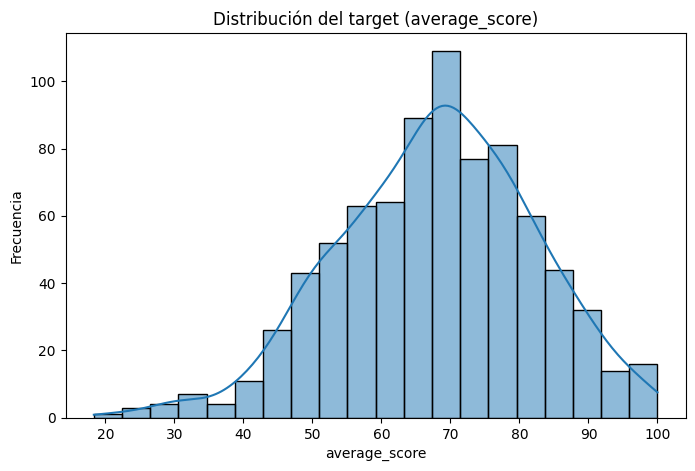

count    800.000000
mean      67.870833
std       14.182767
min       18.333333
25%       58.666667
50%       68.666667
75%       77.666667
max      100.000000
Name: average_score, dtype: float64

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=20, kde=True)
plt.title("Distribución del target (average_score)")
plt.xlabel("average_score")
plt.ylabel("Frecuencia")
plt.show()

y_train.describe()


Podemos observar que la variable objetivo average_score es continua, por lo que se trata de un problema de regresión. Por este motivo, en lugar de métricas de clasificación como Accuracy o AUC, se utilizarán métricas de regresión como el MAE, RMSE, y R^2. Estas métricas nos permite evaluar y comparar los distintos modelos de regresión que se entrenarán más adelante.

## 5. VALIDACIÓN CRUZADA Y SELECCIÓN DE MODELOS

En este apartado se realizará la validación cruzada y la selección de modelos. Asi que el objetivo es comparar distintos modelos de regresión y ver cuál ofrece mejor rendimiento al predecir la nota media average_score, por lo tanto, la métrica principal utilizaremos el MAE, también se tendrán en cuenta el RMSE y el R^2. O sea elegimos las tres porque la métrica principal MAE decidiremos qué modelo es mejor, y mostraremos también las otras dos para tener más información.

Hemos elegido estos tres metricas porque MAE mide cuántos puntos se equivoca el modelo de media, por lo tanto, cuanto más pequeño MAE es mejor. En caunto a RMSE tambien mide el error pero castiga mucho más los errores grandes, o sea si un modelo a veces se equivoca muchísimo en algunos alumnos, su RMSE sube mucho más que el MAE, por eso cuanto más pequeño RMSE es mejor. Por lo tanto, nos sirve para comprobar si algún modelo comete errores muy grandes aunque el MAE sea pequeño. Y R^2 mide qué tan bien el modelo explica las notas en comparación con una predicción simple que sería usar la media, por lo tanto, si R^2 cerca de 1 significa que el modelo explica bastante bien las diferencias entre alumnos, y un R^2 cerca de 0 indica que da igual usar el modelo o poner la media, o sea no mejora mucho. Y si sale en negativo pues el modelo lo hace peor que predecir siempre la media

Para que la evaluación de los modelos sea más fiable, se usará validación cruzada con KFold de 10 partes (k=10), es decir que el conjunto de entrenamiento se divide en 10 trozos y en cada vuelta el modelo se entrena con 9 trozos y se prueba con el trozo que queda libre.
Así que cada modelo se entrena y se evalúa varias veces con divisiones distintas de los datos y al final se hace la media de las métricas (MAE, RMSE, R^2) de las 10 vueltas para obtener un resultado más estable.

Los 5 modelos de regresión que utilizaremos seran LinearRegression que actúa como modelo base sencillo y busca una relación lineal entre las variables y la nota media. Despues esta el KNeighborsRegressor, que predice la nota a partir de alumnos similares en el conjunto de datos. El DecisionTreeRegressor, que aprende reglas en forma de árbol de decisión. El RandomForestRegressor que combina muchos árboles para obtener predicciones más estables. El ultimo es GradientBoostingRegressor que construye árboles de forma secuencial para ir corrigiendo los errores de los anteriores y mejorar de manera progresiva el ajuste.


In [24]:
models = {
    "LinearRegression": LinearRegression(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0)
}

In [25]:
def validacionModelos(X, y):
    resultados = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)
    scoring = {
        "mae": "neg_mean_absolute_error",
        "mse": "neg_mean_squared_error",
        "r2": "r2"
    }
    for nombre, modelo in models.items():
        print(nombre)
        
        scores = cross_validate(modelo,X, y,cv=kfold,scoring=scoring,n_jobs=-1,return_train_score=False)

        mae_folds = -scores["test_mae"]
        rmse_folds = np.sqrt(-scores["test_mse"])
        r2_folds = scores["test_r2"]
        
        print("  MAE en cada fold :", np.round(mae_folds, 2))
        print("  RMSE en cada fold:", np.round(rmse_folds, 2))
        print("  R^2 en cada fold  :", np.round(r2_folds, 3))
        print(f"  MAE medio : {mae_folds.mean():.2f}")
        print(f"  RMSE medio: {rmse_folds.mean():.2f}")
        print(f"  R^2 medio : {r2_folds.mean():.3f}\n")
        
        resultados.append({
            "modelo": nombre,
            "MAE_medio": mae_folds.mean(),
            "RMSE_medio": rmse_folds.mean(),
            "R2_medio": r2_folds.mean()
        })
    
    return pd.DataFrame(resultados).set_index("modelo")


In [26]:
resultados_cv = validacionModelos(X_train, y_train)
resultados_cv


LinearRegression
  MAE en cada fold : [10.32 10.21  9.43  9.95 10.54  9.69  9.94 10.75  9.88 11.69]
  RMSE en cada fold: [13.15 12.46 11.57 12.3  13.01 12.39 11.8  13.15 11.99 14.13]
  R^2 en cada fold  : [0.121 0.07  0.219 0.208 0.232 0.17  0.03  0.247 0.348 0.269]
  MAE medio : 10.24
  RMSE medio: 12.60
  R^2 medio : 0.191

KNeighborsRegressor
  MAE en cada fold : [11.   10.71 11.51 10.45 11.88 10.46 11.32 11.87 10.46 12.21]
  RMSE en cada fold: [14.17 13.25 14.01 12.94 14.53 13.34 13.09 14.61 12.41 15.12]
  R^2 en cada fold  : [-0.02  -0.051 -0.144  0.124  0.041  0.038 -0.194  0.07   0.301  0.163]
  MAE medio : 11.19
  RMSE medio: 13.75
  R^2 medio : 0.033

DecisionTreeRegressor
  MAE en cada fold : [11.48 11.13 12.51 11.78 11.92 11.42 11.69 12.68 11.2  13.96]
  RMSE en cada fold: [14.92 14.15 15.21 15.   14.79 14.15 13.9  15.7  13.49 17.62]
  R^2 en cada fold  : [-0.132 -0.2   -0.349 -0.178  0.007 -0.083 -0.347 -0.075  0.175 -0.138]
  MAE medio : 11.98
  RMSE medio: 14.89
  R^2 med

,MAE_medio,RMSE_medio,R2_medio
modelo,,,
LinearRegression,10.239392,12.595662,0.191173
KNeighborsRegressor,11.187500,13.745678,0.032770
DecisionTreeRegressor,11.976863,14.894334,-0.131896
RandomForestRegressor,11.551757,14.255562,-0.041452
GradientBoostingRegressor,10.597217,13.070451,0.129578


Lo miraremos en un gráfico los resultados para ver mejor.

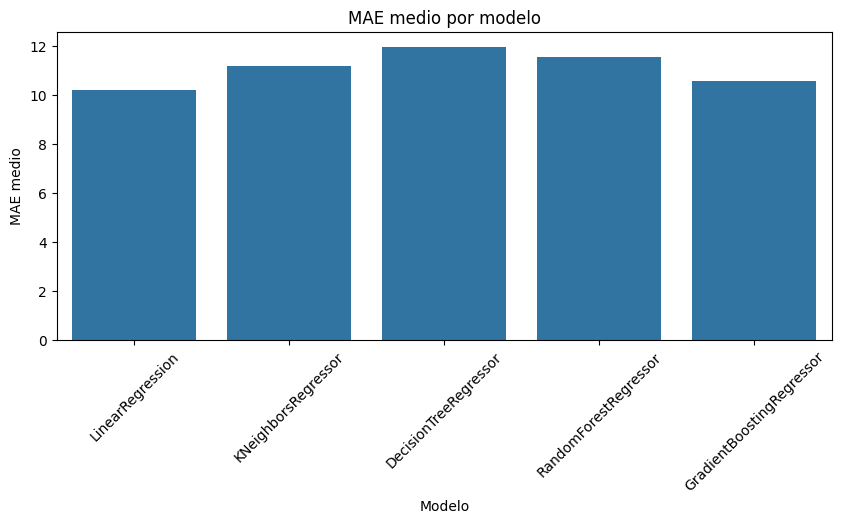

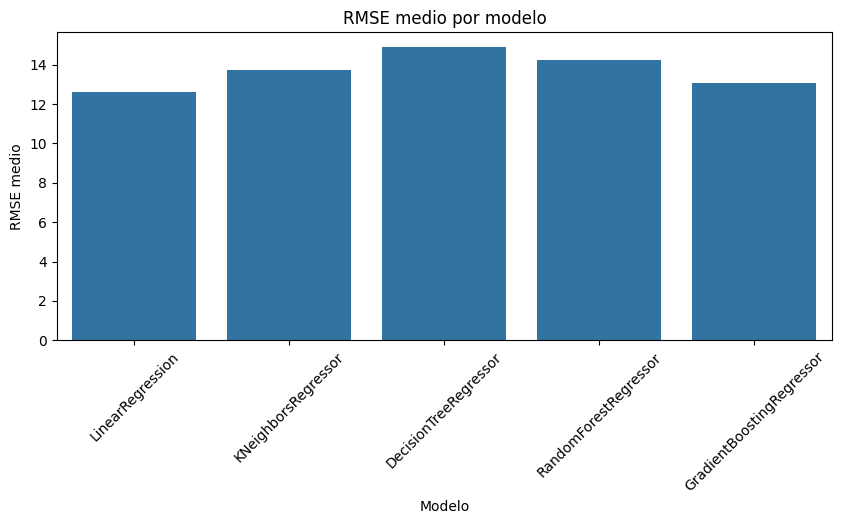

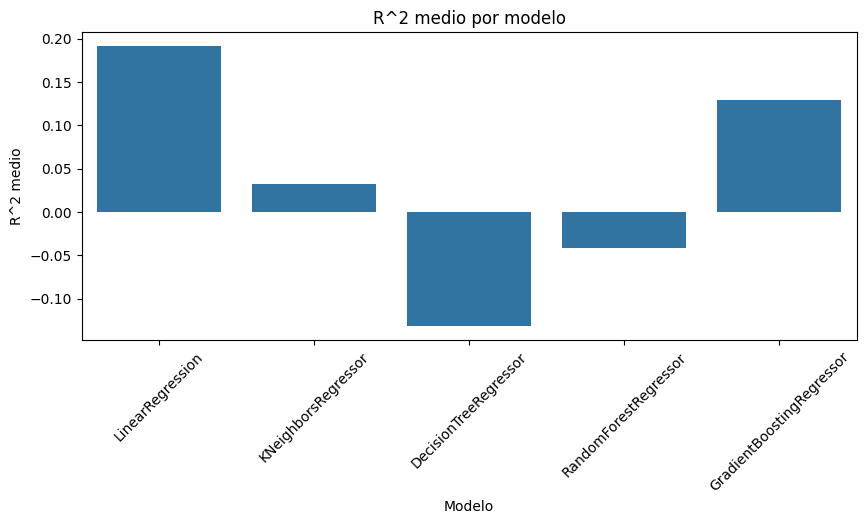

In [27]:
res_plot = resultados_cv.reset_index().rename(columns={"index": "modelo"})

plt.figure(figsize=(10, 4))
sns.barplot(data=res_plot, x="modelo", y="MAE_medio")
plt.title("MAE medio por modelo")
plt.ylabel("MAE medio")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=res_plot, x="modelo", y="RMSE_medio")
plt.title("RMSE medio por modelo")
plt.ylabel("RMSE medio")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=res_plot, x="modelo", y="R2_medio")
plt.title("R^2 medio por modelo")
plt.ylabel("R^2 medio")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.show()

En las tres gráficas comparativas se observa que LinearRegression es el modelo que tiene el MAE medio más bajo y también el RMSE medio más bajo, pero no hay tanta diferencia con el resto de los modelos. Sin embargo, es el que tiene el mejor R^2 medio (0.191), es decir, es el que mejor explica la variación de la nota media average_score.

Los modelos de árboles como el DecisionTreeRegressor y RandomForestRegressor podemos destacar que los valores de R^2 son negativos, o sea lo hacen incluso peor que una línea horizontal que solo predijera siempre la media. Por lo tanto, no están captando bien la relación entre las variables y la nota media.

En KNeighborsRegressor también obtiene un MAE y un RMSE más altos que la regresión lineal, pero un R^2 cerca de 0, pues tampoco mejora mucho el resultado.

En caunto a GradientBoostingRegressor mejora un poco en comparacion a los modelos de árboles, ya que tiene mejor R^2, su MAE y RMSE son un poco mas altos que el LinearRegression, pero el R^2 de LinearRegression es un poco mejor.

En conclusion, se elige LinearRegression como modelo principal, ya que es el que ofrece el mejor resultado de  MAE y RMSE porque tiene menor error, y mayor  R^2 entre todos los modelos.

Para reforzar la elección de LinearRegression como modelo principal, a continuación analizaremos las curvas de aprendizaje y lo compararemos con el resto de modelos. A si podemos comprobar si los resultados de validación cruzada son coherentes, o sea tiene sentido con el comportamiento de cada modelo cuando aumentamos el tamaño del conjunto de entrenamiento.

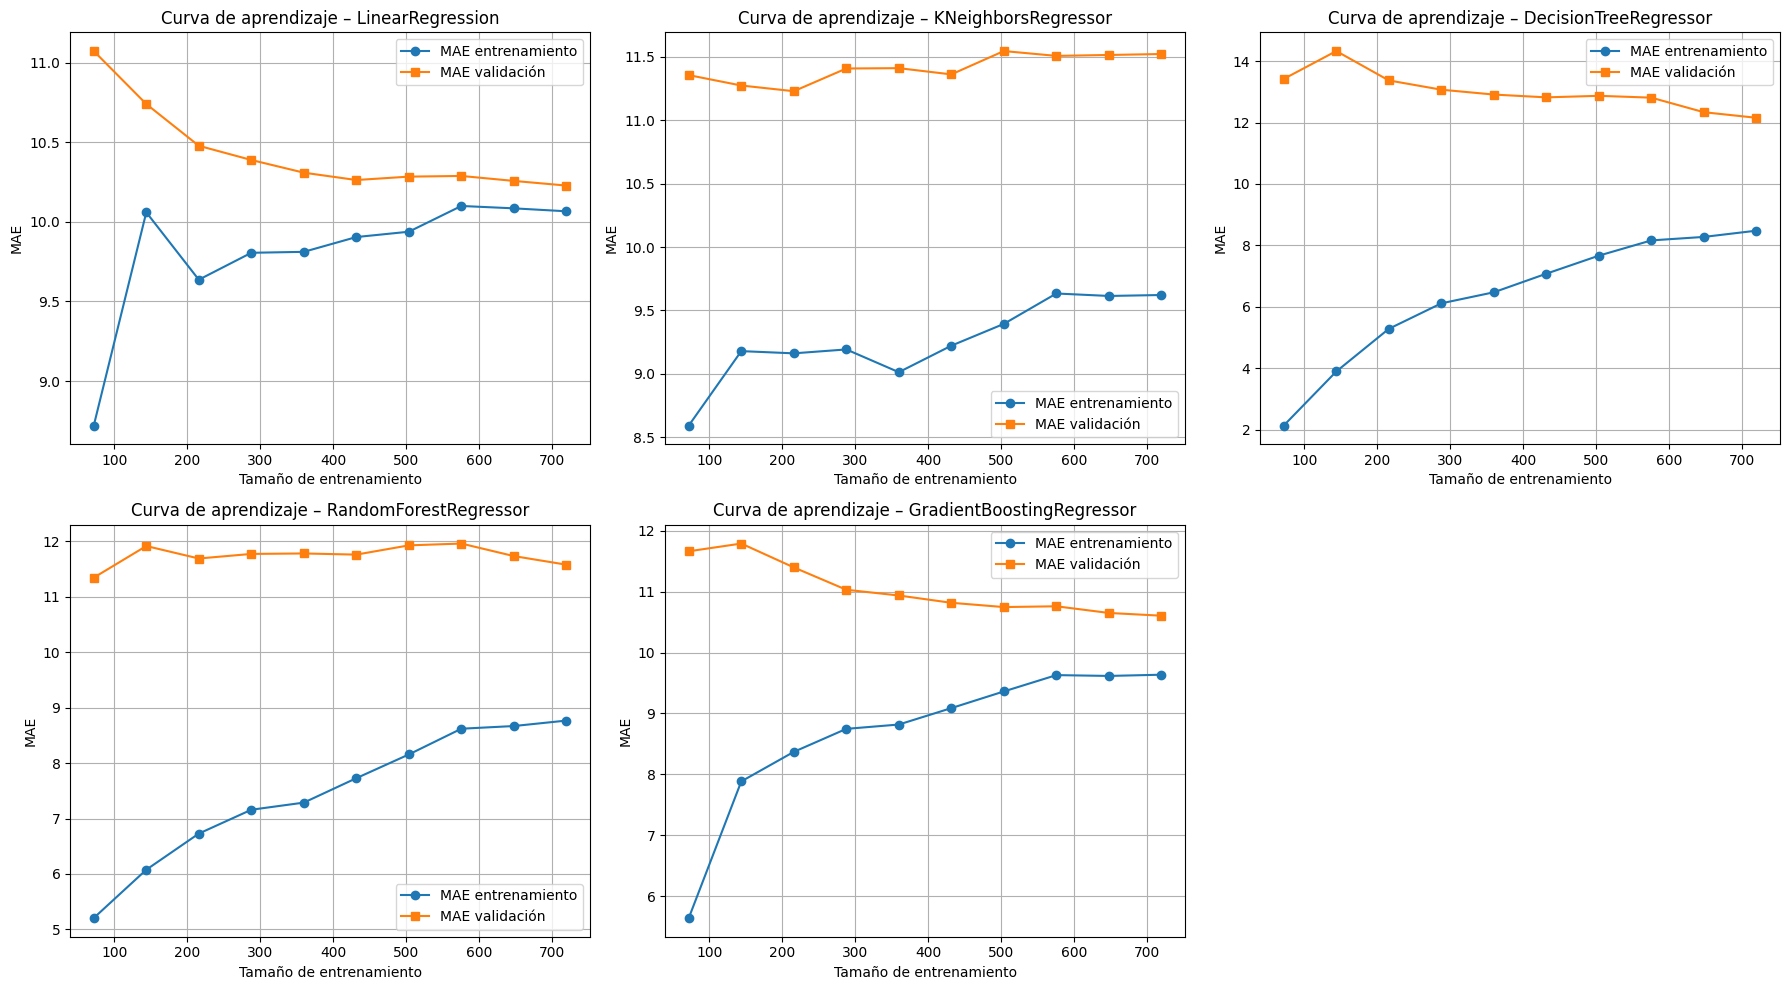

In [28]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 10)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (nombre, modelo) in enumerate(models.items()):
    ts, train_scores, val_scores = learning_curve(
        estimator=modelo,
        X=X_train,
        y=y_train,
        cv=kfold,
        scoring="neg_mean_absolute_error",
        train_sizes=train_sizes,
        n_jobs=-1,
    )
    train_mae = -train_scores.mean(axis=1)
    val_mae   = -val_scores.mean(axis=1)
    ax = axes[i]
    ax.plot(ts, train_mae, marker="o", label="MAE entrenamiento")
    ax.plot(ts, val_mae, marker="s", label="MAE validación")
    ax.set_title(f"Curva de aprendizaje – {nombre}")
    ax.set_xlabel("Tamaño de entrenamiento")
    ax.set_ylabel("MAE")
    ax.grid(True)
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()



En las curvas de aprendizaje se puede observar que el que obtiene mejor rendimiento sigue siendo LinearRegression, ya que cuando aumentamos el tamaño del conjunto de entrenamiento, el MAE de entrenamiento y el de validación se van acercando y se mantienen en valores similares, es decir, las curvas de entrenamiento y validación se juntan rápido y se estabilizan pronto, lo que indica tiempos de aprendizaje cortos y buena capacidad de generalización.

En KNeighborsRegressor, el MAE de validación casi siempre es más alto que en la regresión lineal y casi ni mejora al usar más datos, así que no nos da ninguna ventaja, pues la descartamos. Lo mismo pasa en los modelos de árboles DecisionTreeRegressor y RandomForestRegressor, pero en estos dos casos su MAE validación baja muy poco y MAE entrenamiento no se acerca mucho a la curva de validación.

En caunto a GradientBoostingRegressor lo hace mucho mejor, pero aun así su error de validación sigue siendo un poco peor que el de LinearRegression casi en todos los tamaños de entrenamiento.

Por lo tanto, las curvas de aprendizaje confirman la decisión escogida anteriormente en la validación cruzada que es LinearRegression que es el modelo más equilibrado, con errores bajos tanto en entrenamiento como en validación y un comportamiento estable al aumentar el tamaño de entrenamiento. Ademas, no realizaremos una búsqueda de hiperparámetros porque el modelo seleccionado es LinearRegression, que apenas tiene parámetros que realmente mejoren el rendimiento, y como hemos visto anteriormente en las comparaciones con los otros modelos, la regresión lineal ha sido el que tenido los  mejores resultados según la validación cruzada y las curvas de aprendizaje. Por lo tanto, en lugar de complicar más el proceso con un GridSearchCV que no creemos que aporte alguna  mejora significativa, pues entrenaremos directamente este modelo con el conjunto de entrenamiento y evaluarlo en el conjunto de test.

## 6. EVALUACIÓN EN EL CONJUNTO DE TEST Y CONCLUSIONES

A continuación, haremos la predicción sobre datos no vistos (conjunto de test) para evaluar el rendimiento real del modelo LinearRegression. Se entrena el modelo con todo el conjunto de entrenamiento y se miden sus resultados en test utilizando las métricas MAE, RMSE y R^2, comprobando si tiene un comportamiento similar al observado durante la validación cruzada.

In [29]:
modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)

y_pred_test = modelo_final.predict(X_test)

mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test   = r2_score(y_test, y_pred_test)

print("Resultados en el conjunto de test:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R^2: {r2_test:.3f}")

Resultados en el conjunto de test:
MAE: 9.82
RMSE: 12.41
R^2: 0.272


A partir de los resultados en el conjunto de test, podemos ver que el modelo mantiene un comportamiento parecido al de la validación cruzada. El MAE de 9,82 nos dice que el modelo se equivoca unos 10 puntos en la nota media average_score (ya que la escala es de 0 a 100), por lo tanto, las predicciones estan bastante acertadas pero aún tienen margen de mejora. El RMSE de 12,41 nos dice que cuando el modelo se equivoca, suele hacerlo algo más de 10 puntos y que hay algunos errores algo más grandes. Y en R^2 de 0,272 significa que el modelo solo consigue explicar aproximadamente un 27 % de las diferencias en las notas, o sea que el modelo solo explica una parte limitada de las diferencias entre las notas de los estudiantes.
En resumen, la regresión lineal funciona de forma aceptable y concuerda con lo visto en la validación cruzada, pero todavía no es un modelo perfecto.

Ahora mostraremos gráficamente las predicciones frente a los valores reales del conjunto de test. En este gráfico cada punto será un alumno, en el eje X aparecerá su nota media real (average_score) y en el eje Y la nota media predicha por el modelo. Además, se dibuja una línea roja y = x que representa las predicciones perfectas. Cuanto más cerca estén los puntos de esa línea, mejor estará funcionando la regresión lineal.

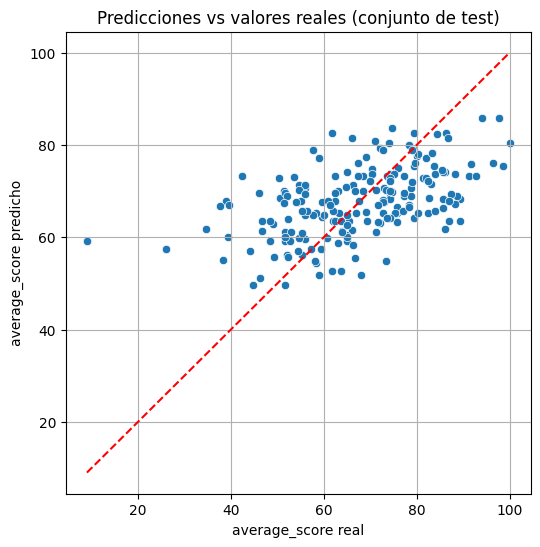

In [30]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel("average_score real")
plt.ylabel("average_score predicho")
plt.title("Predicciones vs valores reales (conjunto de test)")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],"r--")  
plt.grid(True)
plt.show()

Podemos ver que la mayoría de puntos se agrupan alrededor de la línea roja, pero con alguna dispersion. Esto indica que el modelo sigue bien la tendencia, es decir, si tiene mayor nota real, pues tambien mayor nota predicha. Sin embargo, también se ve que muchos puntos no caen exactamente sobre la línea, lo que nos confirma los errores medios comentados antes que la MAE rd aproximadamente 10 y RMSE es aproximadamente 12.
Y vemos que en la parte central, las notas entre 50 y 80, sus predicciones están más concentradas cerca de la línea, mientras que en las notas más bajas y muy altas hay más dispersión, o sea estan mas alejadas de la linea. Esto nos quiere decir que el modelo acierta mejor con los estudiantes con notas medias, y le cuesta predecir a estudiantes con notas bajas o muy altas. Por eso aun hay margen de mejora.

En conclusión, el modelo de regresión lineal ofrece un rendimiento razonable y es coherente con lo que hemos observado en la validación cruzada, aunque todavía tiene margen de mejora, como se ha comentado anteriormente. Como trabajo futuro, sería interesante añadir nuevas variables como hábitos de estudio, horas de ocio, etc. Y probar otros modelos más complejos con una búsqueda de hiperparámetros, con el objetivo de reducir el error y que el modelo sea capaz de predecir las notas de forma más precisa.